# Physics-Informed Neural Networks (PINNs) in Neuromancer

This tutorial demonstrates the use of [PINNs](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) for solving partial differential equations (PDEs) in the Neuromancer library.

<img src="../figs/PINNs.png" width="600">  

### References

[1] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)

[2] https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/tree/main

[3] https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main

## Install (Colab only)
Skip this step when running locally.

In [1]:
# !pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
# !pip install pyDOE

## Imports

In [2]:
# torch and numpy imports
import sys

# import torch
import torch
import torch.nn as nn
import numpy as np

# data imports
from scipy.io import loadmat

# plotting imports
import matplotlib.pyplot as plt

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")

# neuromancer
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
from neuromancer.system import Node
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer


In [3]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Problem Setup

**The 2D steady-state, isotropic diffusion problem** is a classic benchmark problem in heat and mass transfer, where the Laplace equation is solved in a squared domain, under Dirichlet boundary conditions. The problem is given by  

$$ \nabla^2 \boldsymbol{T} = 0. $$

Assuming a two-dimensional space $\Omega = [0,1] \times [0,1]$, the temperature of the plate $T$ varies depending on the spatial position $\boldsymbol{x}$, where $\boldsymbol{x} = [x, y]^T$.

**Boundary Conditions:**

$$T(x, y=1) = T_o,$$
$$T(x=0, y) = T(x=1, y) = T(x, y=0) = 0.$$


### Sample collocation points

In [4]:
# Define number of collocation points in x and y
Nx = 200
Ny = 200

# Define temperature at upper boundary
To = 1.

# Create collocation points
x = torch.linspace(0, 1, Nx).to(device)
y = torch.linspace(0, 1, Ny).to(device)
X, Y = torch.meshgrid(x,y, indexing="ij")
print(X.shape)
print(Y.shape)


torch.Size([200, 200])
torch.Size([200, 200])


### Test data: PDE solution

In [5]:
X_test = X.reshape(-1,1)
Y_test = Y.reshape(-1,1)

###  Construct training datasets

We construct training and development datasets containing [collocation points (CP)](https://en.wikipedia.org/wiki/Collocation_method) of the spatial domain (x,y), and samples of the [boundary conditions (BC)](https://en.wikipedia.org/wiki/Boundary_value_problem).

The dataset is given as:
$\Xi_{\text{train/dev}} = [\texttt{CP}^i, \texttt{BC}^j]$, $i = 1,...,N_{cp}$, $j = 1,...,N_{bp}$  
Where $N_{cp}$ defines number of collocation points, and $N_{bc}$ number of boundary condition samples.

### Samples of boundary conditions (BC)

In [6]:
# Initializing the fields
ic_X = X[:, :]
ic_Y = Y[:, :]
ic_T = X[:, :] * 0.
ic_T[:, -1] = 1.

# Left boundary conditions
left_bc_X = X[[0], :]
left_bc_Y = Y[[0], :]
left_bc_T = ic_T[[0], :]

# Right boundary conditions
right_bc_X = X[[-1], :]
right_bc_Y = Y[[-1], :]
right_bc_T = ic_T[[-1], :]

# Top boundary conditions
top_bc_X = X[:, [-1]]
top_bc_Y = Y[:, [-1]]
top_bc_T = ic_T[:, [-1]]

# Bottom boundary conditions
bottom_bc_X = X[:, [0]]
bottom_bc_Y = Y[:, [0]]
bottom_bc_T = ic_T[:, [0]]


### Number of training samples for BC

In [7]:
X_train_bc = torch.concat([left_bc_X.flatten(), right_bc_X.flatten(), top_bc_X.flatten(), bottom_bc_X.flatten()]).view((-1,1))
Y_train_bc = torch.concat([left_bc_Y.flatten(), right_bc_Y.flatten(), top_bc_Y.flatten(), bottom_bc_Y.flatten()]).view((-1,1))
T_train_bc = torch.concat([left_bc_T.flatten(), right_bc_T.flatten(), top_bc_T.flatten(), bottom_bc_T.flatten()]).view((-1,1))
print(X_train_bc.shape, Y_train_bc.shape, T_train_bc.shape)

N_bc = X_train_bc.shape[0]

torch.Size([800, 1]) torch.Size([800, 1]) torch.Size([800, 1])


### Samples of collocation points (CP) in the interior of the domain

In [8]:
# Domain bounds
x_lb = X_test[0]
x_ub = X_test[-1]
y_lb = Y_test[0]
y_ub = Y_test[-1]
print(f'x_lb = {x_lb}, x_ub = {x_ub}')
print(f'y_lb = {y_lb}, y_ub = {y_ub}')

# Choose (N_collocation) collocation Points to Evaluate the PDE
N_cp = 500
print(f'Number of collocation points for training: {N_cp}')

# Generate collocation points (CP)
X_train_cp = torch.FloatTensor(N_cp, 1).uniform_(float(x_lb), float(x_ub)).to(device)
Y_train_cp = torch.FloatTensor(N_cp, 1).uniform_(float(y_lb), float(y_ub)).to(device)
print(f'Shape of X_train_cp = {X_train_cp.shape}')
print(f'Shape of Y_train_cp = {Y_train_cp.shape}')

# Append collocation points and boundary points for training
X_train = torch.vstack((X_train_cp, X_train_bc)).float().to(device)
Y_train = torch.vstack((Y_train_cp, Y_train_bc)).float().to(device)
print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of Y_train = {Y_train.shape}')

x_lb = tensor([0.], device='mps:0'), x_ub = tensor([1.], device='mps:0')
y_lb = tensor([0.], device='mps:0'), y_ub = tensor([1.], device='mps:0')
Number of collocation points for training: 500
Shape of X_train_cp = torch.Size([500, 1])
Shape of Y_train_cp = torch.Size([500, 1])
Shape of X_train = torch.Size([1300, 1])
Shape of Y_train = torch.Size([1300, 1])


### Plot CP and BC points

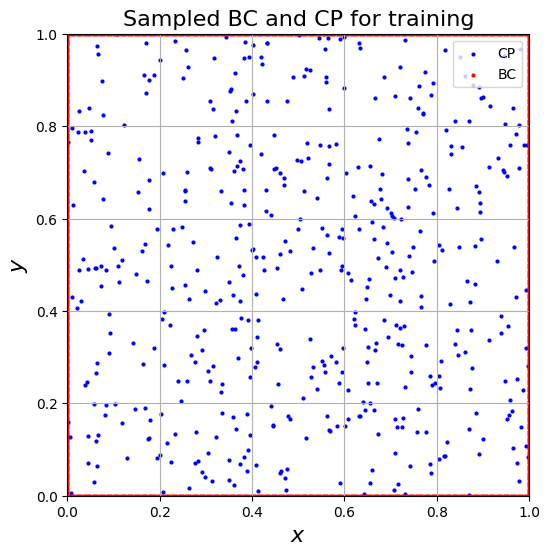

In [9]:
# visualize collocation points for 2D input space (x, y)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.scatter(X_train_cp.detach().cpu().numpy(), Y_train_cp.detach().cpu().numpy(),
            s=4., c='blue', marker='o', label='CP')
ax.scatter(X_train_bc.detach().cpu().numpy(), Y_train_bc.detach().cpu().numpy(),
            s=4., c='red', marker='o', label='BC')
ax.set_title('Sampled BC and CP for training', fontsize=16)
ax.set_xlim(x_lb.detach().cpu(), x_ub.detach().cpu())
ax.set_ylim(y_lb.detach().cpu(), y_ub.detach().cpu())
ax.grid(True)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
ax.legend(loc='upper right')
ax.set_aspect('equal', 'box')
plt.show()

### Create Neuromancer datasets

In [10]:
# turn on gradients for PINN
X_train.requires_grad=True
Y_train.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train.to(device), 'y':Y_train.to(device)}, name='train')
# test dataset
test_data = DictDataset({'x': X_test.to(device), 'y':Y_test.to(device)}, name='test')

# torch dataloaders
batch_size = X_train.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

## Network architecture

In this part, we use an MLP to construct a PINN that will approximate the solution of the PDE, $\hat{T}$:

$$\hat{T} = NN_{\theta}(x,y)$$  

In [11]:
# Neural net to solve the PDE problem bounded in the PDE domain
# Variables in: x, y; variables out: T
net = blocks.MLP(
                 insize=2,                         # x and y (2 dimensions)
                 outsize=1,                        # T(x,y) (1 dimension)
                 hsizes=[30,30],                   # width of hidden layers
                 nonlin=nn.SiLU                    # activation function
                ).to(device)

# symbolic wrapper of the neural net
# Inputs: x and y
# outputs: T
pde_net = Node(net, ['x', 'y'], ['T'], name='net')


In [12]:
print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['x', 'y']
symbolic outputs of the pde_net: ['T']


In [13]:
# Parameter count and structure of the network
print(f" Total number of parameters = {sum(p.numel() for p in net.parameters())}")
print(net)

 Total number of parameters = 1051
MLP(
  (nonlin): ModuleList(
    (0-1): 2 x SiLU()
    (2): Identity()
  )
  (linear): ModuleList(
    (0): Linear(
      (linear): Linear(in_features=2, out_features=30, bias=True)
    )
    (1): Linear(
      (linear): Linear(in_features=30, out_features=30, bias=True)
    )
    (2): Linear(
      (linear): Linear(in_features=30, out_features=1, bias=True)
    )
  )
)


###  Define physics-informed terms

The neural network approximation must satisfy the PDE equation $NN_{\theta}(x,y) \approx T(x,y)$.
Thus we define the residual $f$:

$$f(x,y)=
 \frac{\partial^2 NN_{\theta}(x,y)}{\partial x^2} + \frac{\partial^2 NN_{\theta}(x,y)}{\partial y^2}
 $$

We can obtain the derivatives of the neural net $\frac{\partial^2 NN_{\theta}}{\partial x^2},\frac{\partial^2 NN_{\theta}}{\partial y^2}$ using [automatic diferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

To simplify the implementation of $f$ we exploit the symbolic variable of the Neuromancer library.

In [14]:
# symbolic Neuromancer variables
T = variable('T')  # PDE solution generated as the output of a neural net
x = variable('x')  # spatial coordinate 1
y = variable('y')  # spatial coordinate 2

In [15]:
# get the symbolic derivatives
dT_dx = T.grad(x)
dT_dy = T.grad(y)
d2T_dx2 = dT_dx.grad(x)
d2T_dy2 = dT_dy.grad(y)

# get the PINN form
f = d2T_dx2 + d2T_dy2

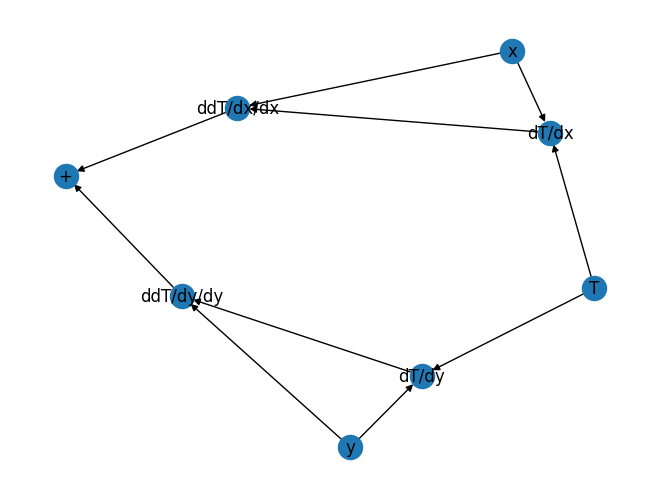

In [16]:
# computational graph of f
f.show()

### Loss function terms

**PDE collocation points Loss:**  
We evaluate the residual $f$ over given number ($N_{cp}$) of collocation points (CP) and minimize the PDE residuals in the following loss function:

$$\ell_{cp}=\frac{1}{N_{cp}}\sum^{N_{cp}}_{i=1}|f(x_c^i,y_c^i)|^2$$

If $f\rightarrow 0$ then our PINN converges to the solution of the PDE.

**PDE boundary conditions Loss:**

We select $N_{bc}$ points from our BC and used them in the following supervised learning loss function:

$$\ell_{bc}=\frac{1}{N_{bc}}\sum^{N_{bc}}_{i=1}|T(x_{b}^i,y_b^i)-NN_{\theta}(t_{b}^i,x_b^i)|^2$$

#### Total loss:
The total loss is just a sum of PDE residuals over CP and supervised learning residuals over BC.

$$\ell_{\text{total}}=\ell_{cp}+\ell_{bc}$$
<!-- $$\ell_{\text{PINN}}=\ell_{f}+\ell_{u} +\ell_{y}$$ -->

In [17]:
# scaling factor for better convergence
scaling_cp = 1.
scaling_bc = 1.

# PDE CP loss (MSE)
l_cp = scaling_cp*(f == torch.tensor(0.).to(device))^2

# PDE BC loss (MSE)
l_bc = scaling_bc*( T[-N_bc:] - T_train_bc == torch.tensor(0.).to(device) )^2 # remember that we concatenated CP and BC

# output constraints to bound the PINN solution
con_1 = (T >= 0) #Passive scalar T is always positive; note: this is optional

##  Train the network to solve the PDE

We use Adam to optimize the parameters $\theta$ of the neural networks $NN_{\theta}(x,y)$ approximating the solution to the PDE equation $T(t,x)$ using the total loss $\ell_{\text{total}}$ evaluated over sampled collocation points CP and boundary condition points BC.

### Define the optimization problem in Neuromancer

In [18]:
# Wrapper for losses and constraints
loss = PenaltyLoss(objectives=[l_cp, l_bc], constraints=[con_1])

# Vanilla PINN
problem = Problem(nodes=[pde_net],       # list of nodes (neural nets) to be optimized
                  loss=loss,             # physics-informed loss function
                  grad_inference=True    # argument for allowing computation of gradients at the inference time
                  )


### Construct trainers and solve

In [19]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)

epochs = 5001

# Trainer for vanilla PINN
trainer = Trainer(problem.to(device),
                  train_data=train_loader,
                  optimizer=optimizer,
                  epochs=epochs,
                  epoch_verbose=1000,
                  train_metric='train_loss',
                  dev_metric='train_loss',
                  eval_metric="train_loss",
                  warmup=epochs,
                  device=device)


In [20]:
# Train vanilla PINN
best_model = trainer.train()


epoch: 0  train_loss: 0.3493269979953766
epoch: 1000  train_loss: 0.03790576383471489
epoch: 2000  train_loss: 0.025070052593946457
epoch: 3000  train_loss: 0.024011658504605293
epoch: 4000  train_loss: 0.023442327976226807
epoch: 5000  train_loss: 0.023147309198975563


In [21]:
# Evaluate trained PINN on test data (all the data in the domain)
pinn = problem.nodes[0]

T_pinn = pinn(test_data.datadict)['T']

# arrange data for plotting
T_pinn = T_pinn.reshape(shape=[Nx,Ny]).detach().cpu()


## Results

### Compute the error and plot solutions
We can compare the estimated result $\hat{T}^*$ with the analytical solution $T_{exact}^*$:

$$T_{exact}^{*} (x^*,y^*) = \sum_{k=1}^{\infty} \frac{2 T_o [1-(-1)^k]}{k \pi} \frac{\sin(k\pi x^*) \sinh(k \pi y^*)} {\sinh(k \pi)}$$

For evaluation purposes and to avoid numerical overflow, we truncate the series solution to $N = 200$ modes.

In [22]:
# Compute the analytical solution
T_exact = np.zeros(shape=(Nx,Ny))
N_modes = 200
To = 1
x_ = np.linspace(0, 1, Nx)
y_ = np.linspace(0, 1, Ny)

for k in range(1,N_modes):
    for i in range(Nx):
        for j in range(Ny):
            T_exact[i,j] += 2 * To * (1-(-1)**k) * np.sin(k*np.pi*x_[i]) * np.sinh(k*np.pi*y_[j])/(k*np.pi * np.sinh(k*np.pi))


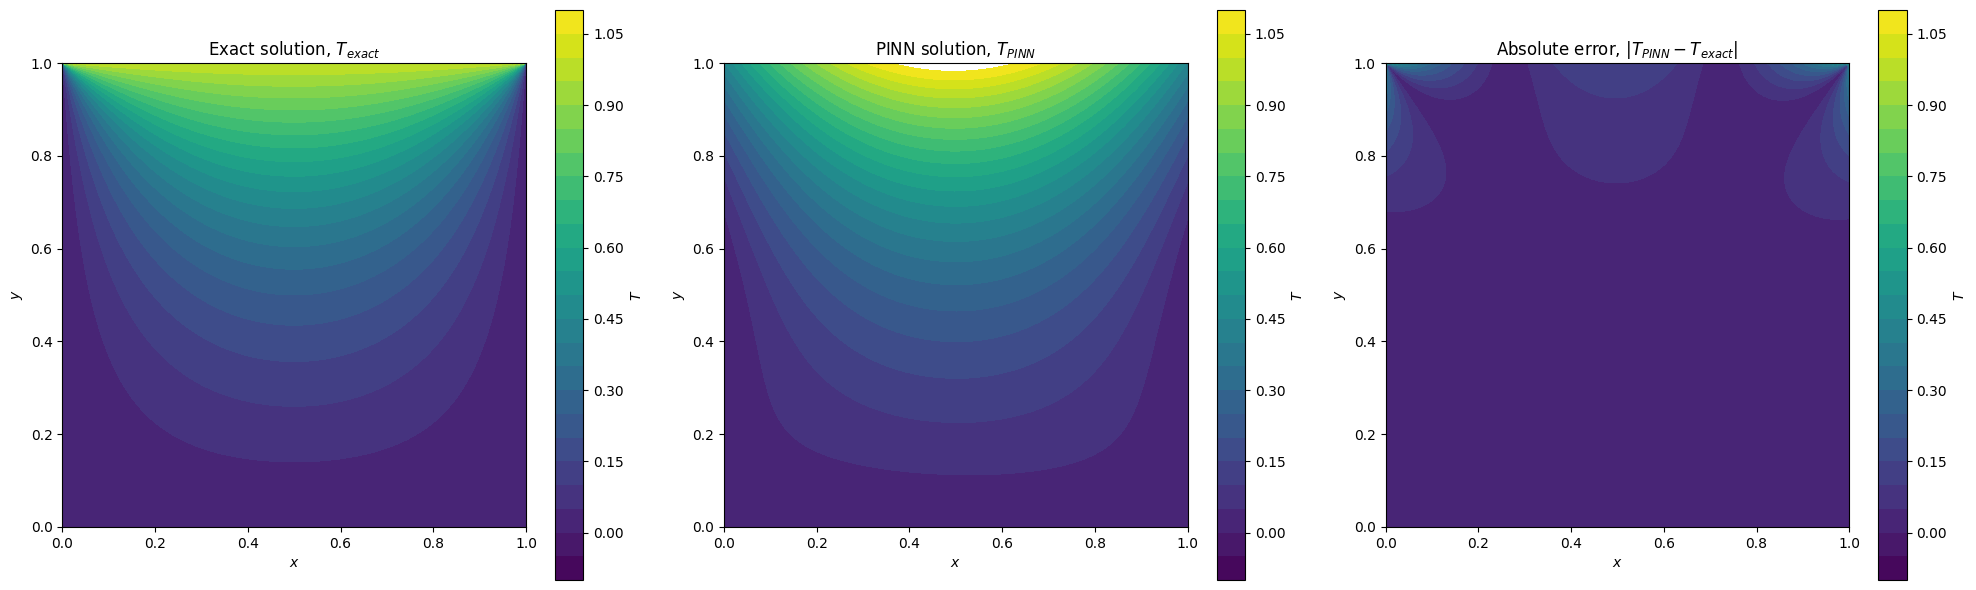

In [23]:
# Plot contour plots (T_exact vs T_pinn vs |T_exact - T_pinn|)
plt.figure(figsize=(20, 6))

# Plot for the first heatmap (Exact solution)
ax1 = plt.subplot(1, 3, 1)
cbarticks = np.arange(-0.1, 1.1, 0.05)
CP1 = plt.contourf(ic_X.cpu(), ic_Y.cpu(), T_exact, cbarticks, cmap='viridis')
plt.title('Exact solution, $T_{exact}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP1, label='$T$')
ax1.set_aspect('equal', adjustable='box')

# Plot for the second heatmap (PINN solution)
ax2 = plt.subplot(1, 3, 2)
CP2 = plt.contourf(ic_X.cpu(), ic_Y.cpu(), T_pinn, cbarticks, cmap='viridis')
plt.title('PINN solution, $T_{PINN}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$T$')
ax2.set_aspect('equal', adjustable='box')

# Plot for the third heatmap (Absolute error between PINN approximation and exact solution)
ax3 = plt.subplot(1, 3, 3)
CP3 = plt.contourf(ic_X.cpu(), ic_Y.cpu(), torch.abs(torch.Tensor(T_exact) - T_pinn), cbarticks, cmap='viridis')
plt.title('Absolute error, $|T_{PINN} - T_{exact}|$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP3, label='$T$')
ax3.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


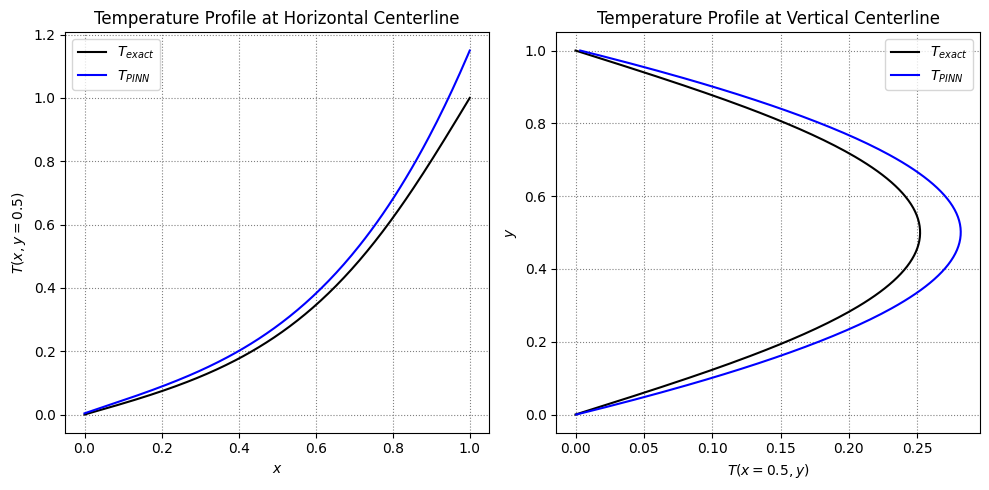

In [24]:
# Calculate the horizontal centerline (middle row) for both datasets
horizontal_centerline_T_exact = T_exact[T_exact.shape[0] // 2, :]
horizontal_centerline_T_pinn = T_pinn[T_pinn.shape[0] // 2, :]

# Calculate the vertical centerline (middle column) for both datasets
vertical_centerline_T_exact = T_exact[:, T_exact.shape[1] // 2]
vertical_centerline_T_pinn = T_pinn[:, T_pinn.shape[1] // 2]

# Create a figure and axis for the plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Temperature at the horizontal centerline vs. x values
ax[0].plot(x_, horizontal_centerline_T_exact, color='black', label='$T_{exact}$')
ax[0].plot(x_, horizontal_centerline_T_pinn, color='blue', label='$T_{PINN}$')
ax[0].set_title('Temperature Profile at Horizontal Centerline')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$T(x,y=0.5)$')
ax[0].grid(True, linestyle=':', color='gray')  # Add dotted grid
ax[0].legend()

# Plot 2: Temperature at the vertical centerline vs. y values
ax[1].plot(vertical_centerline_T_exact, y_, color='black', label='$T_{exact}$')
ax[1].plot(vertical_centerline_T_pinn, y_, color='blue', label='$T_{PINN}$')
ax[1].set_title('Temperature Profile at Vertical Centerline')
ax[1].set_xlabel('$T(x=0.5, y)$')
ax[1].set_ylabel('$y$')
ax[1].grid(True, linestyle=':', color='gray')  # Add dotted grid
ax[1].legend()

plt.tight_layout()
plt.show()
